# Environment Setup


In [ ]:
# Check for TPU availability
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPUClusterResolver() automatically detects TPUs
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    # Check if 'worker' key exists before accessing it
    tpu_spec = tpu.cluster_spec().as_dict()
    if 'worker' in tpu_spec:
        print("Running on TPU:", tpu_spec['worker'])
    else:
        print("Running on TPU, but 'worker' information not found in cluster spec.")
else:
    print("TPU not found, using default strategy.")
    strategy = tf.distribute.get_strategy()

Running on TPU  
Running on TPU, but 'worker' information not found in cluster spec.


# Data Reading and Preprocessing

In [ ]:
import pandas as pd

# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# Define paths to parquet files
train_path = '/content/drive/MyDrive/fhvhv_2022-09_2023-08_h.parquet'  # Use wildcard to match multiple files if needed
test_path = '/content/drive/MyDrive/fhvhv_2023-09_2024-08_h.parquet'
val_path = '/content/drive/MyDrive/fhvhv_2021-09_2022-08_h.parquet'

# Read parquet files into pandas DataFrames
try:
  train_df = pd.read_parquet(train_path)
  test_df = pd.read_parquet(test_path)
  val_df = pd.read_parquet(val_path)

  print("Successfully read parquet files into DataFrames.")

  print("Train DataFrame shape:", train_df.shape)
  print("Test DataFrame shape:", test_df.shape)
  print("Validation DataFrame shape:", val_df.shape)

except FileNotFoundError:
  print(f"Error: One or more parquet files not found. Check file paths: {train_path}, {test_path}, {val_path}")
except Exception as e:
  print(f"An error occurred: {e}")

ValueError: mount failed

# Data Preparation for LSTM without weather features

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming your data is already loaded into train_df, test_df, and val_df

# Preprocess the data
def preprocess_data(df, target_column='PU_count'):
    # Select relevant columns and handle missing values (replace with mean for simplicity)
    df = df[['PU_count']]
    df = df.fillna(df.mean())

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    data = scaler.fit_transform(df)

    return data, scaler

# Prepare data for LSTM
def create_dataset(dataset, look_back=4):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        print(a)
        X.append(a)
        print(X)
        Y.append(dataset[i + look_back, 0])
        break
    return np.array(X), np.array(Y)

# Preprocess and create datasets
train_data, train_scaler = preprocess_data(train_df)
test_data, test_scaler = preprocess_data(test_df)
val_data, val_scaler = preprocess_data(val_df)

look_back = 10 # Example lookback period
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)
X_val, y_val = create_dataset(val_data, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[0.         0.00052493 0.         0.         0.         0.
 0.         0.         0.         0.        ]
[array([0.        , 0.00052493, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])]


# LSTM Model without weather features

In [ ]:
# Build the LSTM model with TPU strategy
with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(tf.keras.layers.LSTM(units=50))
    model.add(tf.keras.layers.Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))
# Save the entire model as a `.keras` zip archive.
model.save('/content/drive/MyDrive/lstm_no_weather.keras')

NameError: name 'strategy' is not defined

## Evaluation

In [ ]:
# Make predictions
#train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
val_predict = model.predict(X_val)

# Invert predictions back to original scale
#train_predict = train_scaler.inverse_transform(train_predict)
#y_train = train_scaler.inverse_transform([y_train])
test_predict = test_scaler.inverse_transform(test_predict)
y_test = test_scaler.inverse_transform([y_test])
val_predict = val_scaler.inverse_transform(val_predict)
y_val = val_scaler.inverse_transform([y_val])

from sklearn.metrics import mean_squared_error

# Calculate MSE for train and test predictions
train_mse = mean_squared_error(y_train[0], train_predict)
test_mse = mean_squared_error(y_test[0], test_predict)
validation_mse = mean_squared_error(y_val[0], val_predict)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Validation MSE: {validation_mse}')

71996/71996 [==============================] - 574s 8ms/step


## Plotting

NameError: name 'test_predict' is not defined

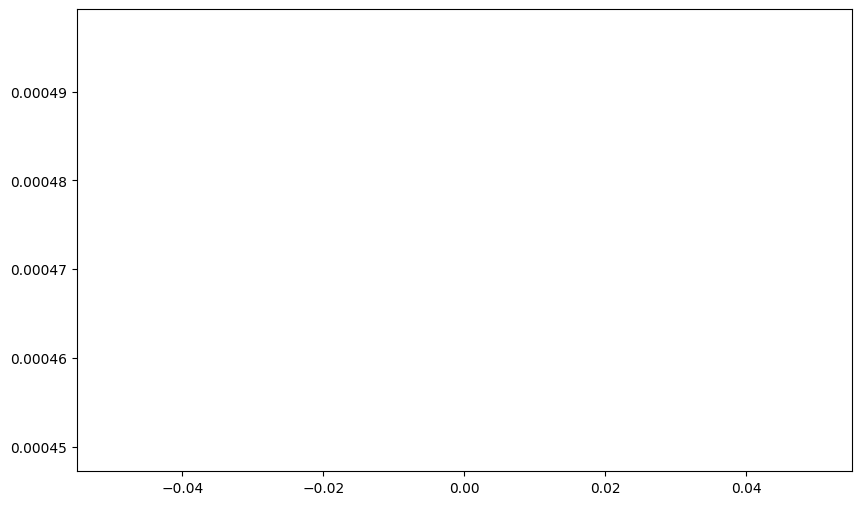

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label='Actual')
plt.plot(test_predict, label='Predicted')
plt.legend()
plt.title('Test Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('PU_count')
plt.show()

#Data Preparation and Preprocessing for Model that includes Weather features

In [ ]:
# Preprocess the data
def preprocess_data(df):
    # Select all features from the dataframe
    # Handle missing values (replace with mean for simplicity)
    df = df.fillna(df.mean())

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    data = scaler.fit_transform(df)

    return data, scaler

# Prepare data for LSTM
def create_dataset(dataset, look_back=4):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :] # Selecting all features
        X.append(a)
        Y.append(dataset[i + look_back, 0]) # Assuming the first column is the target
        # Remove break to process entire dataset
    return np.array(X), np.array(Y)

# Preprocess and create datasets
train_data, train_scaler = preprocess_data(train_df)
test_data, test_scaler = preprocess_data(test_df)
val_data, val_scaler = preprocess_data(val_df)

look_back = 10 # Example lookback period
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)
X_val, y_val = create_dataset(val_data, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
# Get the number of features from the preprocessed data
n_features = X_train.shape[2]

# Train LSTM Model with weather features

In [ ]:
# Build the LSTM model with TPU strategy
with strategy.scope():  # Wrap model creation within TPU strategy scope
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], n_features)))
    model.add(tf.keras.layers.LSTM(units=50))
    model.add(tf.keras.layers.Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model (no changes needed here)
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))  # Adjust epochs and batch_size as needed
# Save the entire model as a `.keras` zip archive.
model.save('/content/drive/MyDrive/lstm_weather.keras')

## Evaluation

In [ ]:
# Make predictions
#train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
val_predict = model.predict(X_val)

# Invert predictions back to original scale
#train_predict = train_scaler.inverse_transform(train_predict)
#y_train = train_scaler.inverse_transform([y_train])
test_predict = test_scaler.inverse_transform(test_predict)
y_test = test_scaler.inverse_transform([y_test])
val_predict = val_scaler.inverse_transform(val_predict)
y_val = val_scaler.inverse_transform([y_val])

from sklearn.metrics import mean_squared_error

# Calculate MSE for train and test predictions
train_mse = mean_squared_error(y_train[0], train_predict)
test_mse = mean_squared_error(y_test[0], test_predict)
validation_mse = mean_squared_error(y_val[0], val_predict)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Validation MSE: {validation_mse}')

71996/71996 [==============================] - 574s 8ms/step


## Plotting

NameError: name 'test_predict' is not defined

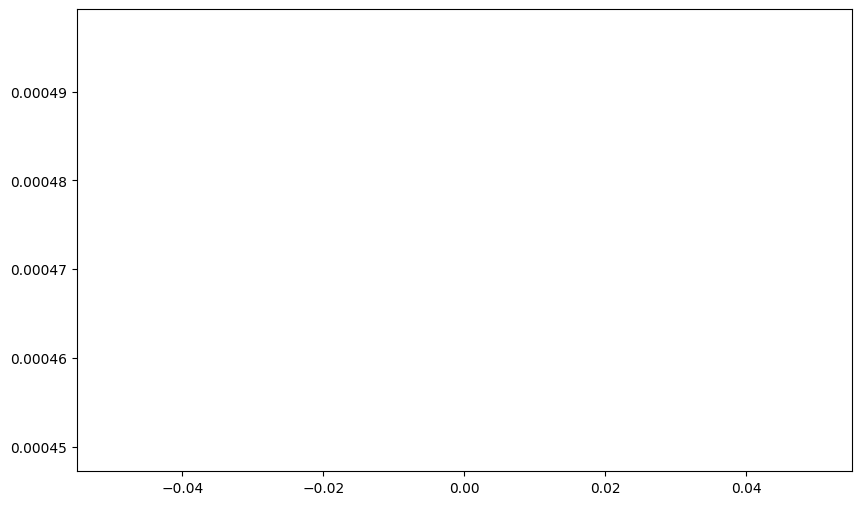

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label='Actual')
plt.plot(test_predict, label='Predicted')
plt.legend()
plt.title('Test Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('PU_count')
plt.show()